In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import math
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
df=pd.read_csv('Lineups and clusters.csv')
df=df.drop('Unnamed: 0',axis=1)

# This notebook shows the implementation of 3 different regression models: Random Forest, SVR, AdaBoost.
# With the first 2 there's a grid search CV and for loops to get the best result, with the last one just a for loop.

In [3]:
#Function to round the probabilities to the nearest .25
def round_prob(x):
    if 0.0<= x <0.125:
        x=0.0
    elif 0.125<= x <0.375:
        x=0.25
    elif 0.375<= x <0.625:
        x=0.5
    elif 0.625<= x <0.875:
        x=0.75
    elif 0.875<= x <1.125:
        x=1.0
    elif 1.125<= x <1.375:
        x=1.25
    elif 1.375<= x <1.625:
        x=1.5
    elif 1.625<= x <1.875:
        x=1.75
    elif 1.875<= x <2.125:
        x=2.0
    elif 2.125<= x <2.375:
        x=2.25
    elif 2.375<= x <2.625:
        x=2.5
    elif 2.625<= x <2.875:
        x=2.75
    elif 2.875<= x <3.125:
        x=3.0
    elif 3.125<= x <3.375:
        x=3.25
    elif 3.375<= x <3.625:
        x=3.5
    elif 3.625<= x <3.875:
        x=3.75
    elif 3.875<= x <4.125:
        x=4.0
    else: 
        x=x
    return x

In [4]:
#Applying the round function of above. 
df['Tot prob 0']=df['Tot prob 0'].apply(round_prob)
df['Tot prob 1']=df['Tot prob 1'].apply(round_prob)
df['Tot prob 2']=df['Tot prob 2'].apply(round_prob)
df['Tot prob 3']=df['Tot prob 3'].apply(round_prob)
df['Tot prob 4']=df['Tot prob 4'].apply(round_prob)
df['Tot prob 5']=df['Tot prob 5'].apply(round_prob)
df['Tot prob 6']=df['Tot prob 6'].apply(round_prob)
df['Tot prob 7']=df['Tot prob 7'].apply(round_prob)
df['NRating']=np.around(df['NRating'],2)

In [5]:
train_columns=['Tot prob 0','Tot prob 1','Tot prob 2','Tot prob 3','Tot prob 4','Tot prob 5','Tot prob 6',
              'Tot prob 7']  #Train columns for the prediction
target_columns=['NRating']  #Target column for the prediction
X= df[train_columns].to_numpy() 
Y= df[target_columns].to_numpy()
scaler = StandardScaler()
#Y = scaler.fit_transform(Y)
length = math.floor(len(X)/1.5)  #Spliting value for training and testing data
train_X = X[:length]   #X_train data
train_Y = Y[:length]   #Y_train data
train_Y= train_Y.reshape(train_Y.shape[0], )
test_X = X[length:]   #X_test data
test_Y = Y[length:]   #Y_test data
test_Y= test_Y.reshape(test_Y.shape[0], )



Grid Search implementation with the train data

In [6]:
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),   #Estimator used for grid search
    param_grid={        
        'n_estimators': (100,200,500,1000,1500),
        'max_depth': (2,3,4,5,6,7,8,None),
        'min_samples_split': (2,3,5,6,8,10),
        'max_features': ('auto','sqrt','log2',5,6,2)
    },   #Parameters of that estimator
    cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)   #Splitting value and metric for evaluation
    
grid_result = gsc.fit(train_X, train_Y)
best_params = grid_result.best_params_   #Best parameters after running grid search
    
rfr = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                            min_samples_split=best_params['min_samples_split'],max_features=best_params['max_features']
                            ,random_state=1,n_jobs=-1)   #Best parameters usage for random forest
rfr.fit(train_X,train_Y)
pred_t=rfr.predict(train_X)
y_pred_r=rfr.predict(test_X)
print(mean_squared_error(pred_t,train_Y))  #Mean Squared Error between train data and its prediction.
print(mean_squared_error(y_pred_r,test_Y))  #Mean Squared Error between test data and its prediction.
print(best_params)  

61.26795441360112
53.2642861346771
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 100}


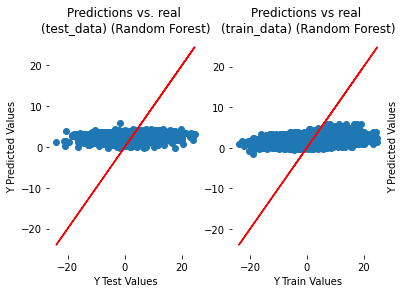

In [7]:
#Graph of both predictions; test and train data vs the real data with random forest.
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(test_Y,test_Y,color='r')
ax1.scatter(test_Y,y_pred_r)
ax1.set_title('Predictions vs. real \n(test_data) (Random Forest)')
ax1.set_xlabel('Y Test Values')
ax1.set_ylabel('Y Predicted Values')
plt.sca(ax1)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax2.plot(train_Y,train_Y,color='r')
ax2.scatter(train_Y,pred_t)
ax2.set_title('Predictions vs real \n(train_data) (Random Forest)')
ax2.set_xlabel('Y Train Values')
ax2.set_ylabel('Y Predicted Values')
ax2.yaxis.set_label_position('right')
plt.sca(ax2)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [8]:
gsc_s = GridSearchCV(
    estimator=SVR(),   #Estimator used for grid search
    param_grid={        
        'kernel': ('rbf','poly'),
        'C': (0.001,0.01,0.1,1,10),
        'epsilon': (0.1,0.5,1,2,5),
        'gamma': (0.001,0.01,0.1,1)
    },   #Parameters of that estimator
    cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)  #Splitting value and metric for evaluation
    
grid_result_s = gsc_s.fit(test_X, test_Y)
best_params_s = grid_result_s.best_params_  #Best parameters after running grid search
    
rfr_s = SVR(kernel=best_params_s['kernel'],C=best_params_s['C'],epsilon=best_params_s['epsilon'],
          gamma=best_params_s['gamma'],verbose=0)    #Best parameters usage for SVR
rfr_s.fit(train_X,train_Y)
pred_ts=rfr_s.predict(train_X)
y_pred_rs=rfr_s.predict(test_X)
print(mean_squared_error(pred_ts,train_Y))   #Mean Squared Error between train data and its prediction.
print(mean_squared_error(y_pred_rs,test_Y))  #Mean Squared Error between test data and its prediction.
print(best_params_s)


62.35945806549071
54.972559338524256
{'C': 10, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}


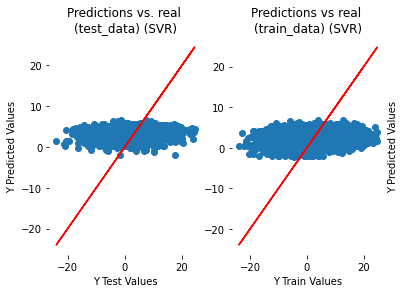

In [9]:
#Graph of both predictions; test and train data vs the real data with SVR
f, (ax3, ax4) = plt.subplots(1, 2)
ax3.plot(test_Y,test_Y,color='r')
ax3.scatter(test_Y,y_pred_rs)
ax3.set_title('Predictions vs. real \n(test_data) (SVR)')
ax3.set_xlabel('Y Test Values')
ax3.set_ylabel('Y Predicted Values')
plt.sca(ax3)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax4.plot(train_Y,train_Y,color='r')
ax4.scatter(train_Y,pred_ts)
ax4.set_title('Predictions vs real \n(train_data) (SVR)')
ax4.set_xlabel('Y Train Values')
ax4.set_ylabel('Y Predicted Values')
ax4.yaxis.set_label_position('right')
plt.sca(ax4)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

The implementation using for loops with the same paramaters as in Grid Search CV and calculation of the MSE in test and train data. 

In [10]:
#Random Forest parameters
n_estimators = [10,20,50,100,200,500,1000,1500]
max_depth = [2,3,4,5,6,7,8,None]
min_samples_split = [2,3,5,6,8,10]
max_features = ['auto','sqrt','log2',5,6,2,3]
#Empty lists
n_esti=[]
max_d=[]
min_s=[]
max_f=[]
mse_train=[]
mse_test=[]
#For loop to check every combination
for i in n_estimators:
    for j in max_depth:
        for k in min_samples_split:
            for l in max_features:
                rfr = RandomForestRegressor(n_estimators = i,max_depth = j,min_samples_split = k,
                                            max_features = l,random_state = 1,n_jobs=-1)
                rfr.fit(train_X,train_Y)
                pred_t=rfr.predict(train_X)
                y_pred_r=rfr.predict(test_X)
                n_esti.append(i)
                max_d.append(j)
                min_s.append(k)
                max_f.append(l)
                mse_train.append(mean_squared_error(train_Y,pred_t))
                mse_test.append(mean_squared_error(test_Y,y_pred_r))

#New DF with all combinations
df_random=pd.DataFrame()
df_random['trees'] = n_esti
df_random['max_depth'] = max_d
df_random['min_split'] = min_s
df_random['max_characteristics'] = max_f
df_random['mse train'] = mse_train
df_random['mse test'] = mse_test

In [12]:
df_random.sort_values(by='mse train',ascending=True).head(10)

,trees,max_depth,min_split,max_characteristics,mse train,mse test
1976,500,NaN,2,log2,39.796732,64.247894
1980,500,NaN,2,3,39.796732,64.247894
2316,1000,NaN,2,3,39.797075,64.152425
2312,1000,NaN,2,log2,39.797075,64.152425
2648,1500,NaN,2,log2,39.800901,64.112674
2652,1500,NaN,2,3,39.800901,64.112674
2315,1000,NaN,2,2,39.807246,63.854342
2311,1000,NaN,2,sqrt,39.807246,63.854342
2647,1500,NaN,2,sqrt,39.807598,63.798593
2651,1500,NaN,2,2,39.807598,63.798593


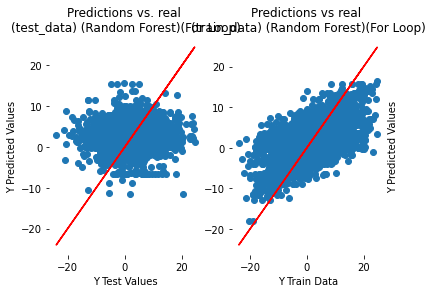

In [13]:
#Using one of the best combinations based on the MSE in the training data.
rfr = RandomForestRegressor(n_estimators = 500,max_depth = None,min_samples_split = 2,
                                        max_features = 3,random_state = 1,n_jobs=-1)
rfr.fit(train_X,train_Y)
pred_t=rfr.predict(train_X)
y_pred_r=rfr.predict(test_X)
f, (ax5, ax6) = plt.subplots(1, 2)
ax5.plot(test_Y,test_Y,color='r')
ax5.scatter(test_Y,y_pred_r)
ax5.set_title('Predictions vs. real \n(test_data) (Random Forest)(For Loop)')
ax5.set_xlabel('Y Test Values')
ax5.set_ylabel('Y Predicted Values')
plt.sca(ax5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax6.plot(train_Y,train_Y,color='r')
ax6.scatter(train_Y,pred_t)
ax6.set_title('Predictions vs real \n(train_data) (Random Forest)(For Loop)')
ax6.set_xlabel('Y Train Data')
ax6.set_ylabel('Y Predicted Values')
ax6.yaxis.set_label_position('right')
plt.sca(ax6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [14]:
#SVR parameters
kernel=['rbf','poly']
C=[0.001,0.01,0.1,1.0,10.0]
epsilon=[0.1,0.5,1.0,2.0,5.0]
gamma=[0.001,0.01,0.1,1.0]
#Empty lists
kernel_list=[]
c_list=[]
eps_list=[]
gamma_list=[]
mse_train_svr=[]
mse_test_svr=[]
#For loop to check every combination
for i in kernel:
    for j in C:
        for k in epsilon:
            for l in gamma:
                rfr_s = SVR(kernel = i,C = j,epsilon = k,gamma = l,verbose=0)
                rfr_s.fit(train_X,train_Y)
                pred_ts=rfr_s.predict(train_X)
                y_pred_rs=rfr_s.predict(test_X)
                kernel_list.append(i)
                c_list.append(j)
                eps_list.append(k)
                gamma_list.append(l)
                mse_train_svr.append(mean_squared_error(train_Y,pred_ts))
                mse_test_svr.append(mean_squared_error(test_Y,y_pred_rs))
    
#New DF with all combinations
df_svr=pd.DataFrame()
df_svr['Kernel'] = kernel_list 
df_svr['C'] = c_list 
df_svr['Epsilon'] = eps_list
df_svr['Gamma'] = gamma_list
df_svr['mse train'] = mse_train_svr
df_svr['mse test'] = mse_test_svr

In [15]:
df_svr.sort_values(by='mse train',ascending=True).head(10)

,Kernel,C,Epsilon,Gamma,mse train,mse test
95,rbf,10.0,2.0,1.0,52.768501,60.660545
91,rbf,10.0,1.0,1.0,52.910447,60.235970
87,rbf,10.0,0.5,1.0,53.045314,60.536456
99,rbf,10.0,5.0,1.0,53.116931,59.071887
83,rbf,10.0,0.1,1.0,53.174003,60.709490
71,rbf,1.0,1.0,1.0,58.189941,55.278921
75,rbf,1.0,2.0,1.0,58.227472,55.471088
67,rbf,1.0,0.5,1.0,58.249930,55.594188
63,rbf,1.0,0.1,1.0,58.350873,55.771523
79,rbf,1.0,5.0,1.0,58.421855,55.027189


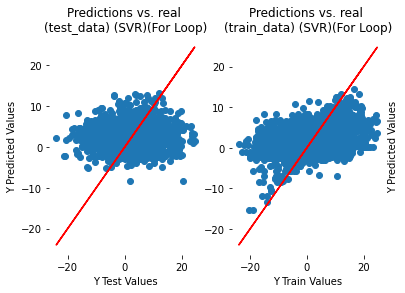

In [16]:
#Using one of the best combinations based on the MSE in the training data.
rfr_s = SVR(kernel = 'rbf',C = 10,epsilon = 2,gamma = 1,verbose=0)
rfr_s.fit(train_X,train_Y)
pred_ts=rfr_s.predict(train_X)
y_pred_rs=rfr_s.predict(test_X)
f, (ax7, ax8) = plt.subplots(1, 2)
ax7.plot(test_Y,test_Y,color='r')
ax7.scatter(test_Y,y_pred_rs)
ax7.set_title('Predictions vs. real \n(test_data) (SVR)(For Loop)')
ax7.set_xlabel('Y Test Values')
ax7.set_ylabel('Y Predicted Values')
plt.sca(ax7)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax8.plot(train_Y,train_Y,color='r')
ax8.scatter(train_Y,pred_ts)
ax8.set_title('Predictions vs. real \n(train_data) (SVR)(For Loop)')
ax8.set_xlabel('Y Train Values')
ax8.set_ylabel('Y Predicted Values')
ax8.yaxis.set_label_position('right')
plt.sca(ax8)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [17]:
#AdaBoost Regressor parameters
base_estimator=[RandomForestRegressor(n_estimators=500),SVR(kernel='poly',degree=5,C=0.1,epsilon=1),
                SVR(kernel = 'rbf',C = 10,epsilon = 2,gamma = 1,verbose=0),
                RandomForestRegressor(n_estimators=500,min_samples_split=2,max_features=3,random_state=1
                                      ,n_jobs=-1)]
n_estiada=[200,500,1000]
learning_rate=[0.1,1,0.5,]
loss=['linear','square']
#Empty lists
base_list=[]
n_estiada_list=[]
lr_list=[]
loss_list=[]
mse_train_ada=[]
mse_test_ada=[]
#For loop to check every combination
for i in base_estimator:
    for j in n_estiada:
        for k in learning_rate:
            for l in loss:
                rfr_a = AdaBoostRegressor(base_estimator = i,n_estimators = j,learning_rate = k,
                                          loss = l)
                rfr_a.fit(train_X,train_Y)
                pred_ta=rfr_a.predict(train_X)
                y_pred_ra=rfr_a.predict(test_X)
                base_list.append(str(i))
                n_estiada_list.append(j)
                lr_list.append(k)
                loss_list.append(l)
                mse_train_ada.append(mean_squared_error(train_Y,pred_ta))
                mse_test_ada.append(mean_squared_error(test_Y,y_pred_ra))
    
#New DF with all combinations
df_ada=pd.DataFrame()
df_ada['Base Estimator'] = base_list 
df_ada['# of Estimators'] = n_estiada_list 
df_ada['Learning Rae'] = lr_list
df_ada['Loss'] = loss_list
df_ada['mse train'] = mse_train_ada
df_ada['mse test'] = mse_test_ada

In [18]:
df_ada.sort_values(by = 'mse train',ascending=True).head(10)

,Base Estimator,# of Estimators,Learning Rae,Loss,mse train,mse test
54,"RandomForestRegressor(max_features=3, n_estima...",200,0.1,linear,41.434996,62.559868
66,"RandomForestRegressor(max_features=3, n_estima...",1000,0.1,linear,41.522851,62.556213
60,"RandomForestRegressor(max_features=3, n_estima...",500,0.1,linear,41.524951,62.538471
0,RandomForestRegressor(n_estimators=500),200,0.1,linear,41.545705,62.953483
12,RandomForestRegressor(n_estimators=500),1000,0.1,linear,41.551466,62.859296
6,RandomForestRegressor(n_estimators=500),500,0.1,linear,41.554305,62.650738
70,"RandomForestRegressor(max_features=3, n_estima...",1000,0.5,linear,41.920111,62.186937
58,"RandomForestRegressor(max_features=3, n_estima...",200,0.5,linear,41.985161,62.662718
16,RandomForestRegressor(n_estimators=500),1000,0.5,linear,42.020210,62.772240
4,RandomForestRegressor(n_estimators=500),200,0.5,linear,42.098446,63.702631


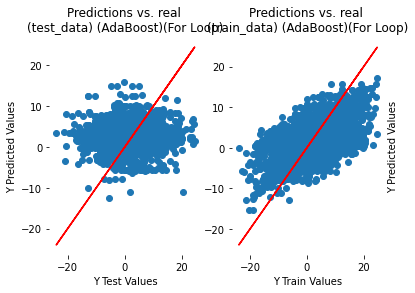

In [19]:
#Using one of the best combinations based on the MSE in the training data.
rfr_a = AdaBoostRegressor(RandomForestRegressor(n_estimators=500,min_samples_split=2,max_features=3,
                                                random_state=1,n_jobs=-1),loss='linear',learning_rate=0.1,
                           n_estimators=200)
rfr_a.fit(train_X,train_Y)
pred_ta=rfr_a.predict(train_X)
y_pred_ra=rfr_a.predict(test_X)
f, (ax9, ax10) = plt.subplots(1, 2)
ax9.plot(test_Y,test_Y,color='r')
ax9.scatter(test_Y,y_pred_ra)
ax9.set_title('Predictions vs. real \n(test_data) (AdaBoost)(For Loop)')
ax9.set_xlabel('Y Test Values')
ax9.set_ylabel('Y Predicted Values')
plt.sca(ax9)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax10.plot(train_Y,train_Y,color='r')
ax10.scatter(train_Y,pred_ta)
ax10.set_title('Predictions vs. real \n(train_data) (AdaBoost)(For Loop)')
ax10.set_xlabel('Y Train Values')
ax10.set_ylabel('Y Predicted Values')
ax10.yaxis.set_label_position('right')
plt.sca(ax10)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# The best performance based on the mean squared error of the train data was obtained with the Random Forest Regressor. 
# If the MSE of the test data was the metric to evaluate the performance, the data doesn't fit at all, neither in training or test data as shown below.

In [20]:
df_random.sort_values(by='mse test',ascending=True).head(10)

,trees,max_depth,min_split,max_characteristics,mse train,mse test
394,20,3.0,5,log2,61.932954,53.039111
405,20,3.0,6,3,61.932954,53.039111
384,20,3.0,2,3,61.932954,53.039111
380,20,3.0,2,log2,61.932954,53.039111
401,20,3.0,6,log2,61.932954,53.039111
387,20,3.0,3,log2,61.932954,53.039111
391,20,3.0,3,3,61.932954,53.039111
398,20,3.0,5,3,61.932954,53.039111
415,20,3.0,10,log2,61.930477,53.046779
419,20,3.0,10,3,61.930477,53.046779


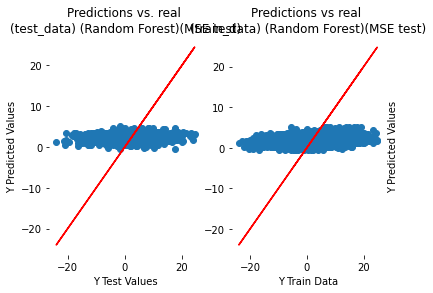

In [21]:
rfr_test = RandomForestRegressor(n_estimators = 20,max_depth = 3,min_samples_split = 5,
                                        max_features = 'log2',random_state = 1,n_jobs=-1)
rfr_test.fit(train_X,train_Y)
pred_t_test=rfr_test.predict(train_X)
y_pred_r_test=rfr_test.predict(test_X)
f, (ax11, ax12) = plt.subplots(1, 2)
ax11.plot(test_Y,test_Y,color='r')
ax11.scatter(test_Y,y_pred_r_test)
ax11.set_title('Predictions vs. real \n(test_data) (Random Forest)(MSE test)')
ax11.set_xlabel('Y Test Values')
ax11.set_ylabel('Y Predicted Values')
plt.sca(ax11)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax12.plot(train_Y,train_Y,color='r')
ax12.scatter(train_Y,pred_t_test)
ax12.set_title('Predictions vs real \n(train_data) (Random Forest)(MSE test)')
ax12.set_xlabel('Y Train Data')
ax12.set_ylabel('Y Predicted Values')
ax12.yaxis.set_label_position('right')
plt.sca(ax12)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# It's completely wrong and not logical that the range of predicted net rating is between 10 and -10. That's why the MSE of the test prediction wasn't used. 